In [1]:
pip install seaborn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import gc
from sklearn.metrics import classification_report

In [3]:
tr_id = pd.read_csv('train_identity.csv')
tr_tran = pd.read_csv('train_transaction.csv')

print(f'Size of tr_id rows:{tr_id.shape[0]}, columns: {tr_id.shape[1]}')
print(f'Size of tr_tran rows:{tr_tran.shape[0]}, columns: {tr_tran.shape[1]}')
#Merging the datasets:

tr = tr_tran.merge(tr_id,on=['TransactionID'],how='left')
print(f'Size of tr - rows : {tr.shape[0]}, columns : {tr.shape[1]}')

tr.shape


Size of tr_id rows:144233, columns: 41
Size of tr_tran rows:590540, columns: 394
Size of tr - rows : 590540, columns : 434


(590540, 434)

In [4]:
tr_GB = tr.memory_usage(deep = True).sum()/1024**3
print(f'tr df is using {tr_GB:.2f} GB of data')

tr df is using 2.51 GB of data


In [5]:
del tr_id
del tr_tran
gc.collect

<function gc.collect(generation=2)>

In [6]:
tr = tr.truncate(after=50000)
tr.shape

(50001, 434)

In [7]:
tr.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [8]:
def reduce_mem_usage(df):

    start_mem = df.memory_usage(index=True, deep=True).sum() / 1024**2
    start_mem_GB = df.memory_usage(index=True, deep=True).sum() / 1024**3
    print(f'Initial memory usage of dataframe is {start_mem:.2f} MB/{start_mem_GB:.2f} GB')
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage(index=True, deep=True).sum() / 1024**2
    end_mem_GB = df.memory_usage(index=True, deep=True).sum() / 1024**3
    reduction = 100 * (start_mem - end_mem) / start_mem
    print(f'Memory usage after optimization is: {end_mem:.2f} MB/{end_mem_GB:.2f} GB')
    print(f'Decreased by {reduction:.1f}%')
    
    return df

train = reduce_mem_usage(tr)
    
    

Initial memory usage of dataframe is 217.88 MB/0.21 GB
Memory usage after optimization is: 42.87 MB/0.04 GB
Decreased by 80.3%


In [9]:
total_mv= train.isnull().sum().to_frame()                         
percent_mv = (train.isnull().sum()/train.isnull().count()*100)   

pd.concat([total_mv, percent_mv], axis=1, keys=['MisVal', '%age']).transpose()

,,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
MisVal,0,0.0,0.0,0.0,0.0,0.0,0.0,697.000000,3.000,6.000,235.000000,...,33953.000000,38327.000000,39180.000000,38361.000000,33932.000000,33932.000000,33932.000000,33932.000000,33933.000000,35650.000000
%age,0,0.0,0.0,0.0,0.0,0.0,0.0,1.393972,0.006,0.012,0.469991,...,67.904642,76.652467,78.358433,76.720466,67.862643,67.862643,67.862643,67.862643,67.864643,71.298574


Target Column : isFraud


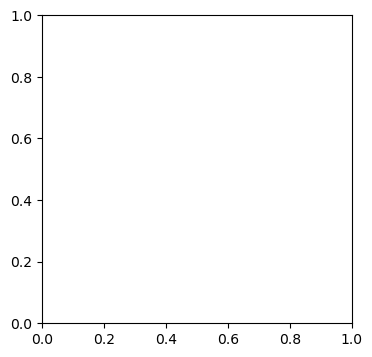

In [10]:







tc = train['isFraud'].value_counts()
tp = train['isFraud'].value_counts()/len(train)

print('Target Column : isFraud')
pd.concat([tc,tp], axis=1, keys=['Count', 'Percent'])
def plot_count(feature, title, df, size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
   # g = sns.countplot(pd.df[feature], order = df[feature].value_counts().index[:30], palette='Set3')
    #g.set_title("Num and %age of {}".format(title))
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.1f}%'.format(100*height/total),
                ha="center") 
    plt.show() 
plot_count('isFraud',  'train: isFraud', df=train, size=1)

In [11]:
cat_features = ['ProductCD','card4','card6', 'P_emaildomain', 'R_emaildomain',
                'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'DeviceType', 'DeviceInfo', 'id_12', 'id_15',
                'id_16','id_23','id_27','id_28','id_29','id_30','id_31',
                'id_33','id_34','id_35','id_36','id_37','id_38']

num_features = [x for x in train.columns.values[2:] if x not in cat_features] 

features = num_features + cat_features

print('Categorical features :', len(cat_features))


print('Numerical features : ',len(num_features))

Categorical features : 31
Numerical features :  401


In [12]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
y=train['isFraud']

scaler = StandardScaler()

ohe = OneHotEncoder(handle_unknown='ignore')

#cat_features = cat_features.astype(str)
new_list = [str(item) for item in cat_features]

column_trans = ColumnTransformer(
    [('ohe', ohe, new_list)], remainder='passthrough', n_jobs=-1)
train.columns = train.columns.astype(str)
tcs = pd.DataFrame(column_trans.fit_transform(train,y))
train.head()
train=train.join(tcs)
train.shape

(50001, 1853)

In [13]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,1409,1410,1411,1412,1413,1414,1415,1416,1417,1418
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,32.0


In [14]:
scaler = StandardScaler()
train[num_features] = scaler.fit_transform(train[num_features])
print (train.head())

   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD     card1  \
0        2987000        0      -1.707454       -0.279863         W  0.818302   
1        2987001        0      -1.707451       -0.465249         W -1.459380   
2        2987002        0      -1.707240       -0.324449         W -1.070353   
3        2987003        0      -1.707148       -0.366689         W  1.675873   
4        2987004        0      -1.707126       -0.366689         H -1.104199   

      card2     card3       card4     card5  ...   1409  1410   1411   1412  \
0       NaN -0.267467    discover -1.456731  ...    NaN   NaN    NaN    NaN   
1  0.234914 -0.267467  mastercard -2.449320  ...    NaN   NaN    NaN    NaN   
2  0.775603 -0.267467        visa -0.861177  ...    NaN   NaN    NaN    NaN   
3  1.259709 -0.267467  mastercard -2.077099  ...    NaN   NaN    NaN    NaN   
4  0.926493 -0.267467  mastercard -2.449320  ...  166.0   NaN  542.0  144.0   

   1413 1414 1415  1416  1417  1418  
0   Na

In [15]:
del ohe, column_trans,scaler
gc.collect

<function gc.collect(generation=2)>

In [16]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,1409,1410,1411,1412,1413,1414,1415,1416,1417,1418
0,2987000,0,-1.707454,-0.279863,W,0.818302,NaN,-0.267467,discover,-1.456731,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,-1.707451,-0.465249,W,-1.459380,0.234914,-0.267467,mastercard,-2.449320,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,-1.707240,-0.324449,W,-1.070353,0.775603,-0.267467,visa,-0.861177,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,-1.707148,-0.366689,W,1.675873,1.259709,-0.267467,mastercard,-2.077099,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,-1.707126,-0.366689,H,-1.104199,0.926493,-0.267467,mastercard,-2.449320,...,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,32.0


In [17]:
train.drop(cat_features, axis=1, inplace=True)
print(train.shape)

(50001, 1822)


In [18]:
print(train.head())

   TransactionID  isFraud  TransactionDT  TransactionAmt     card1     card2  \
0        2987000        0      -1.707454       -0.279863  0.818302       NaN   
1        2987001        0      -1.707451       -0.465249 -1.459380  0.234914   
2        2987002        0      -1.707240       -0.324449 -1.070353  0.775603   
3        2987003        0      -1.707148       -0.366689  1.675873  1.259709   
4        2987004        0      -1.707126       -0.366689 -1.104199  0.926493   

      card3     card5     addr1    addr2  ...   1409  1410   1411   1412  \
0 -0.267467 -1.456731  0.220847  0.21076  ...    NaN   NaN    NaN    NaN   
1 -0.267467 -2.449320  0.316093  0.21076  ...    NaN   NaN    NaN    NaN   
2 -0.267467 -0.861177  0.363717  0.21076  ...    NaN   NaN    NaN    NaN   
3 -0.267467 -2.077099  1.754318  0.21076  ...    NaN   NaN    NaN    NaN   
4 -0.267467 -2.449320  1.220936  0.21076  ...  166.0   NaN  542.0  144.0   

   1413  1414  1415  1416  1417  1418  
0   NaN   NaN   NaN   

   TransactionID  isFraud  TransactionDT  TransactionAmt     card1     card2  \
0        2987000        0      -1.707454       -0.279863  0.818302       NaN   
1        2987001        0      -1.707451       -0.465249 -1.459380  0.234914   
2        2987002        0      -1.707240       -0.324449 -1.070353  0.775603   
3        2987003        0      -1.707148       -0.366689  1.675873  1.259709   
4        2987004        0      -1.707126       -0.366689 -1.104199  0.926493   

      card3     card5     addr1    addr2  ...   1409  1410   1411   1412  \
0 -0.267467 -1.456731  0.220847  0.21076  ...    NaN   NaN    NaN    NaN   
1 -0.267467 -2.449320  0.316093  0.21076  ...    NaN   NaN    NaN    NaN   
2 -0.267467 -0.861177  0.363717  0.21076  ...    NaN   NaN    NaN    NaN   
3 -0.267467 -2.077099  1.754318  0.21076  ...    NaN   NaN    NaN    NaN   
4 -0.267467 -2.449320  1.220936  0.21076  ...  166.0   NaN  542.0  144.0   

   1413  1414  1415  1416  1417  1418  
0   NaN   NaN   NaN   

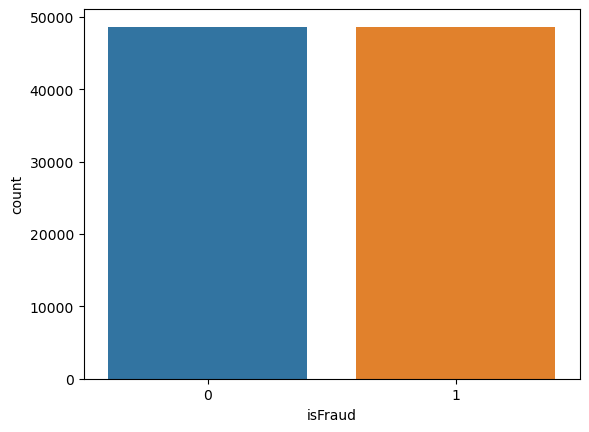

In [19]:
from sklearn.utils import resample
y=train['isFraud']
df_majority = train[y == 0]

df_minority = train[y == 1]
size_major = len(df_majority)

y_majority = y[y == 0]
y_minority = y[y == 1]

# Downsampling
df_minority_upsampled = resample(df_minority,replace=True,n_samples = size_major,random_state=42)  

train = pd.concat([df_majority, df_minority_upsampled])
y_minority_upsampled = y_minority[df_minority_upsampled.index]
y = pd.concat([y_majority, y_minority_upsampled])

sns.countplot(x = y);
print(train.head(),y.head())
print(train.shape,y.shape)

In [20]:
import numpy as np
import tensorflow as tf
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(train.shape[1],)),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(train.shape[1], activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train, train, epochs=10)
new_data = model.predict(train)

Epoch 1/10
3041/3041 [==============================] - 17s 5ms/step - loss: nan - accuracy: 1.0000
Epoch 2/10
3041/3041 [==============================] - 16s 5ms/step - loss: nan - accuracy: 1.0000
Epoch 3/10
3041/3041 [==============================] - 17s 5ms/step - loss: nan - accuracy: 1.0000
Epoch 4/10
3041/3041 [==============================] - 17s 6ms/step - loss: nan - accuracy: 1.0000
Epoch 5/10
3041/3041 [==============================] - 17s 5ms/step - loss: nan - accuracy: 1.0000
Epoch 6/10
3041/3041 [==============================] - 17s 5ms/step - loss: nan - accuracy: 1.0000
Epoch 7/10
3041/3041 [==============================] - 17s 5ms/step - loss: nan - accuracy: 1.0000
Epoch 8/10
3041/3041 [==============================] - 17s 6ms/step - loss: nan - accuracy: 1.0000
Epoch 9/10
3041/3041 [==============================] - 17s 6ms/step - loss: nan - accuracy: 1.0000
Epoch 10/10
3041/3041 [==============================] - 8s 2ms/step


In [21]:
imputer = SimpleImputer(strategy='median')
train.columns = train.columns.astype(str)
imputer.fit(train)
X_train = imputer.transform(train)
print(X_train.shape)
y.shape

(97288, 1822)


(97288,)

In [22]:
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [23]:
y=train['isFraud']
train.drop("isFraud", axis=1, inplace=True)
train.drop("TransactionID", axis=1, inplace=True)

In [24]:
train.head()

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,1409,1410,1411,1412,1413,1414,1415,1416,1417,1418
0,-1.707454,-0.279863,0.818302,NaN,-0.267467,-1.456731,0.220847,0.21076,-0.278330,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1.707451,-0.465249,-1.459380,0.234914,-0.267467,-2.449320,0.316093,0.21076,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1.707240,-0.324449,-1.070353,0.775603,-0.267467,-0.861177,0.363717,0.21076,0.415996,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-1.707148,-0.366689,1.675873,1.259709,-0.267467,-2.077099,1.754318,0.21076,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-1.707126,-0.366689,-1.104199,0.926493,-0.267467,-2.449320,1.220936,0.21076,NaN,NaN,...,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,32.0


In [25]:
#training the test data=30%,train data=70%
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X_train, y,test_size=0.3, stratify=y)

In [26]:
#SMOTE analysis
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=42)
os_data_X,os_data_y=os.fit_resample(train_X, train_y)

In [27]:
#KNN Classification
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
for i in range (1,10,2):
  neigh = KNeighborsClassifier(n_neighbors=i)
  neigh.fit(train_X,train_y)
  predict = neigh.predict(test_X)
  print("classification report of k= ", i)
  print(classification_report(predict,test_y))

classification report of k=  1
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     14134
           1       1.00      0.97      0.98     15053

    accuracy                           0.98     29187
   macro avg       0.98      0.98      0.98     29187
weighted avg       0.98      0.98      0.98     29187

classification report of k=  3
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     13693
           1       1.00      0.94      0.97     15494

    accuracy                           0.97     29187
   macro avg       0.97      0.97      0.97     29187
weighted avg       0.97      0.97      0.97     29187

classification report of k=  5
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     13299
           1       1.00      0.92      0.96     15888

    accuracy                           0.96     29187
   macro avg       0.96      0.96  

In [ ]:
#Support Vector Machine Classification
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(train_X, train_y)
predict = classifier.predict(test_X)
print(classification_report(predict,test_y))

In [ ]:
train.head()

In [ ]:
train.X.isna().sum().sum()

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(train_X, train_y)
print("Accuracy:",nb.score(test_X, test_y))
y_pred = nb.predict(test_X)

crpt = classification_report(test_y, y_pred)
print("\n\nClassification Report\n")
print(crpt)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
clf_rf_down = RandomForestClassifier(random_state=42)
model_rf_down = clf_rf_down.fit(train_X, train_y)
y_pred = model_rf_down.predict(test_X)
crpt = classification_report(test_y, y_pred)
print("\n\nClassification Report\n")
print(crpt)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_y, y_pred)
print("Confusion Matrix\n")
print(cm)

In [ ]:
from xgboost import XGBClassifier
XGB_model = XGBClassifier(seed=42,
                      n_estimators=500,
                      max_depth=10,
                      learning_rate=0.2)
model_xgb_down = XGB_model.fit(train_X, train_y)
y_pred = model_xgb_down.predict(test_X)

crpt = classification_report(test_y, y_pred)
print("\n\nClassification Report\n")
print(crpt)

In [ ]:
#Finally we the model's accuracy through logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=1e20)
model.fit(train_X, train_y)
preds = model.predict(test_X)
crpt = classification_report(test_y, preds)
print("\n\nClassification Report\n")
print(crpt)